# TC Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import xarray as xr
import requests
from io import BytesIO
import numpy as np


sys.path.append("../../../functions")
from tcs import Extract_Circle
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from ind_setup.plotting import plot_bar_probs
from ind_setup.tables import plot_df_table


In [3]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

## Get Data

In [4]:
update_data = False
path_data = "../../../data"

In [5]:
if update_data:
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
    tcs = download_ibtracs(url, basin = basin)
    tcs.to_netcdf(f"{path_data}/tcs_{basin}.nc")
else:
    tcs = xr.load_dataset(f"{path_data}/tcs_{basin}.nc")

In [6]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns)

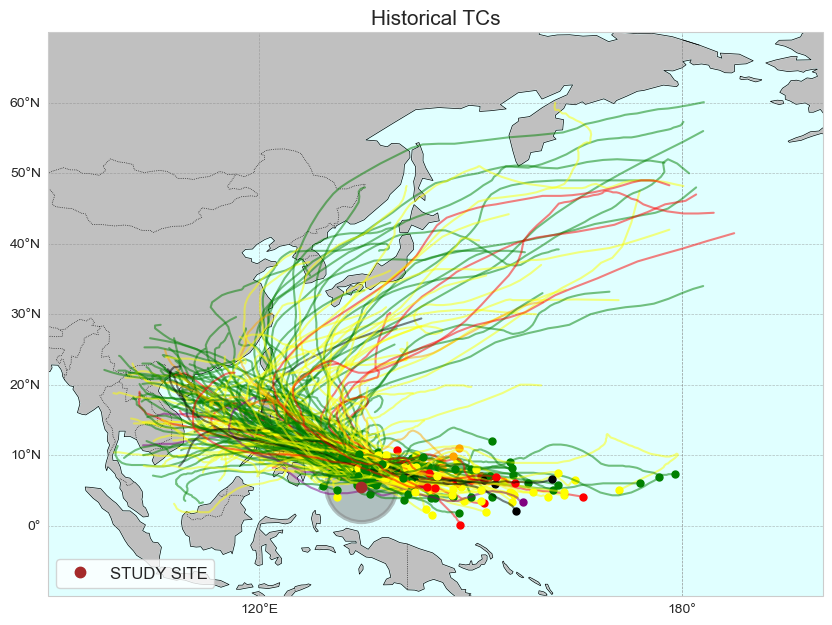

In [7]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel, tcs_sel_params.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)

## Severe TCs

In [8]:
tcs_sel_params_severe = tcs_sel_params.where(tcs_sel_params.category >=3, drop=True)
tcs_sel_severe = tcs_sel.sel(storm=tcs_sel_params_severe.storm)

Text(0.5, 1.0, 'Severe Historical TCs [Categories 3, 4 and 5]')

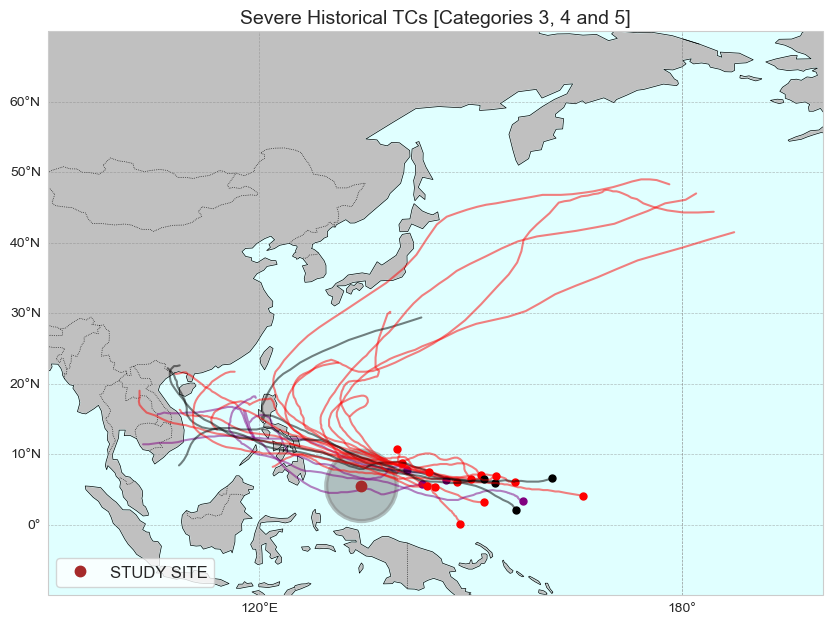

In [9]:

lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel_severe, tcs_sel_params_severe.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)
ax.set_title('Severe Historical TCs [Categories 3, 4 and 5]', fontsize = 14)

## Count TCs by category

In [10]:
u, c = np.unique(tcs_sel_params.category, return_counts=True)

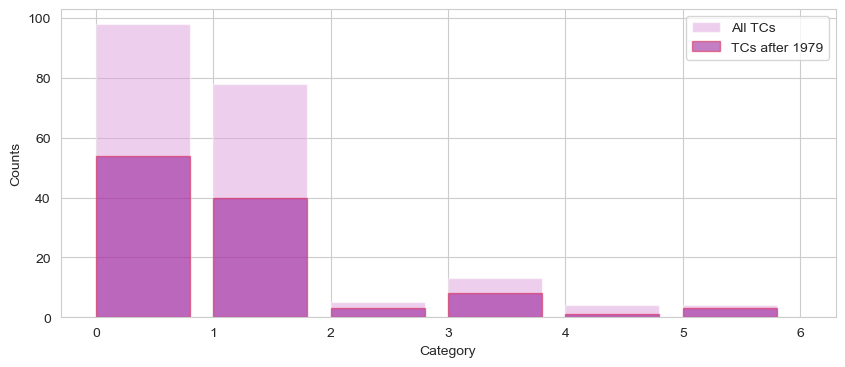

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.grid(zorder = -1)
tcs_sel_params.category.plot.hist(bins=range(7), ax=ax, color='plum', alpha=0.5, edgecolor= None, width = .8, linewidth=1, label = 'All TCs')
tcs_sel_params.where(tcs_sel_params.dmin_date.dt.year >=1979, 
                     drop = True).category.plot.hist(bins=range(7), ax=ax, 
                                                     color='darkmagenta', alpha=0.5, edgecolor='crimson', width = .8, linewidth=1, label = 'TCs after 1979')
ax.set_xlabel('Category')
ax.set_ylabel('Counts')

ax.legend()

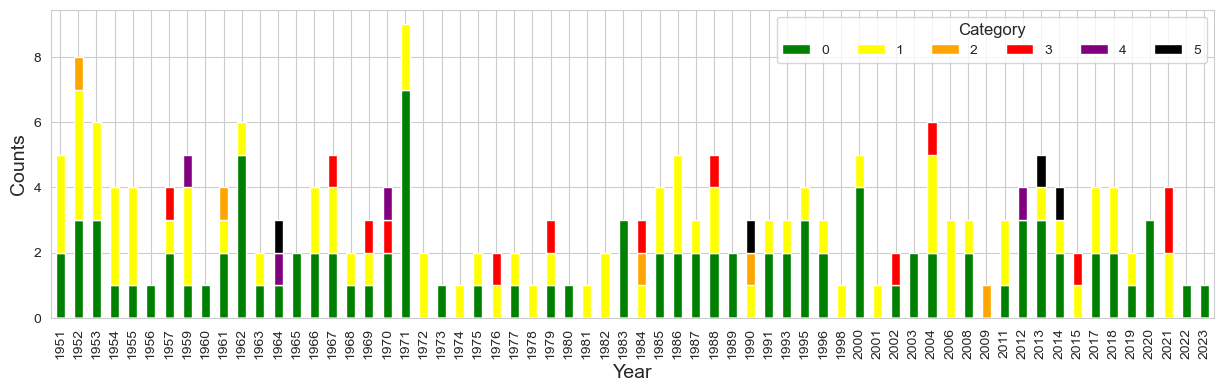

In [12]:
fig, ax = plt.subplots(1, figsize=(15, 4))
df_tcs = tcs_sel_params.to_dataframe()
df_tcs['year'] = df_tcs.dmin_date.dt.year
df_tcs.groupby('year').category.value_counts().unstack().plot(ax = ax, kind = 'bar', stacked = True, color = ['green', 'yellow', 'orange', 'red', 'purple', 'black'])
ax.set_ylabel('Counts', fontsize = 14)
ax.set_xlabel('Year', fontsize = 14)
ax.legend(ncols = 6).set_title('Category', prop = {'size': 12})

<Axes: ylabel='Number TCs'>

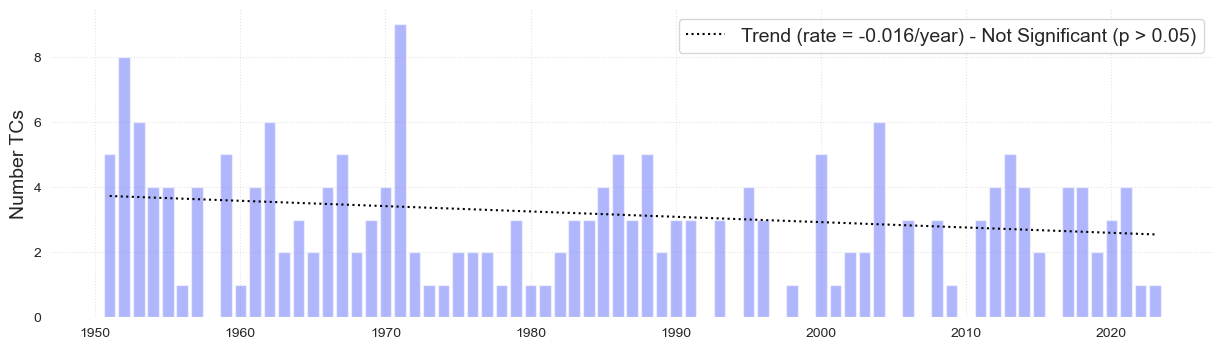

In [13]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
plot_bar_probs(x = u, y = cu, figsize= (15, 4), trendline = True,
               y_label =  'Number TCs')

<Axes: ylabel='Number of severe TCs'>

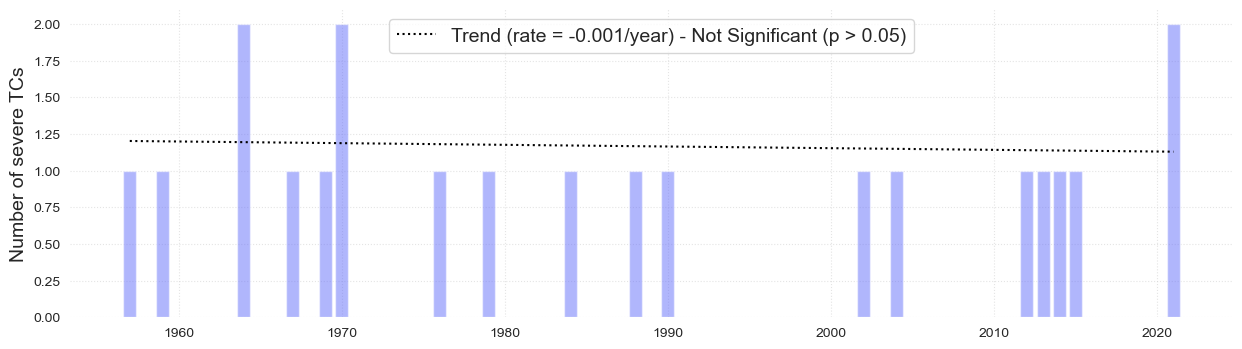

In [14]:
tcs_sel_severe_params = tcs_sel_params.where(tcs_sel_params.category >=3, drop = True)
time = tcs_sel_severe_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
plot_bar_probs(x = u, y = cu, figsize= (15, 4), trendline = True,
               y_label =  'Number of severe TCs')

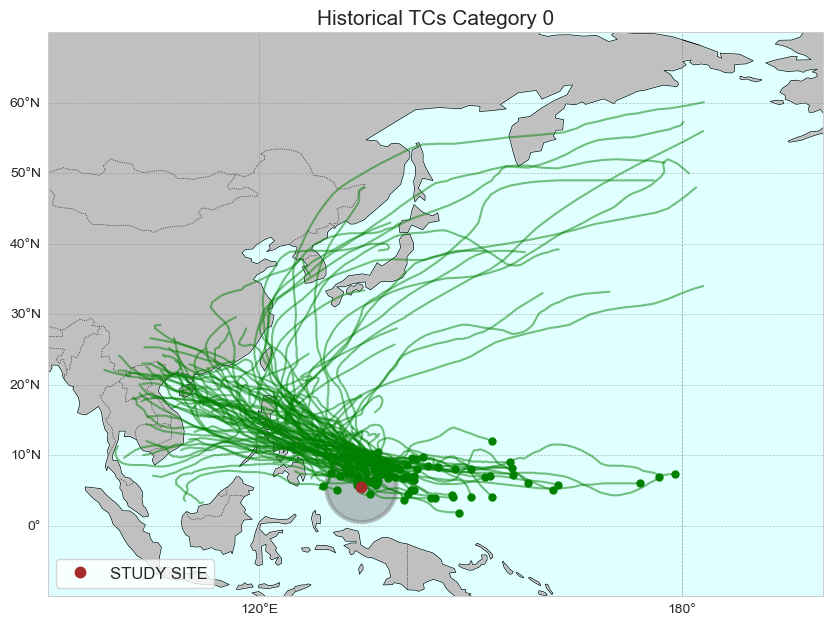

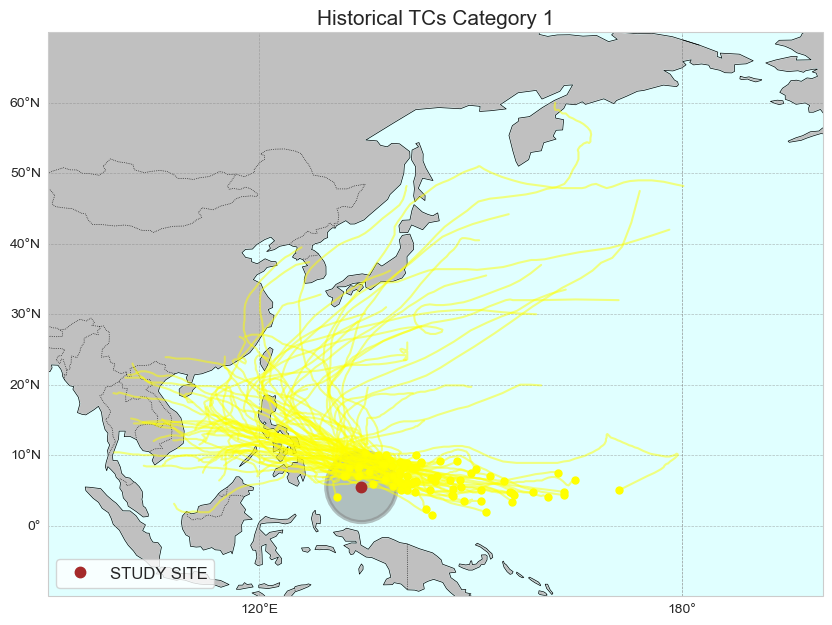

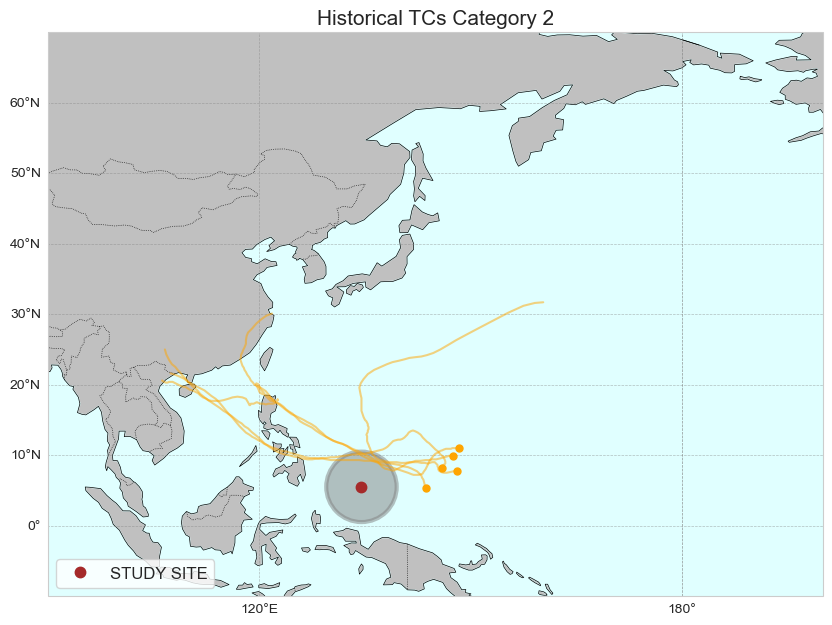

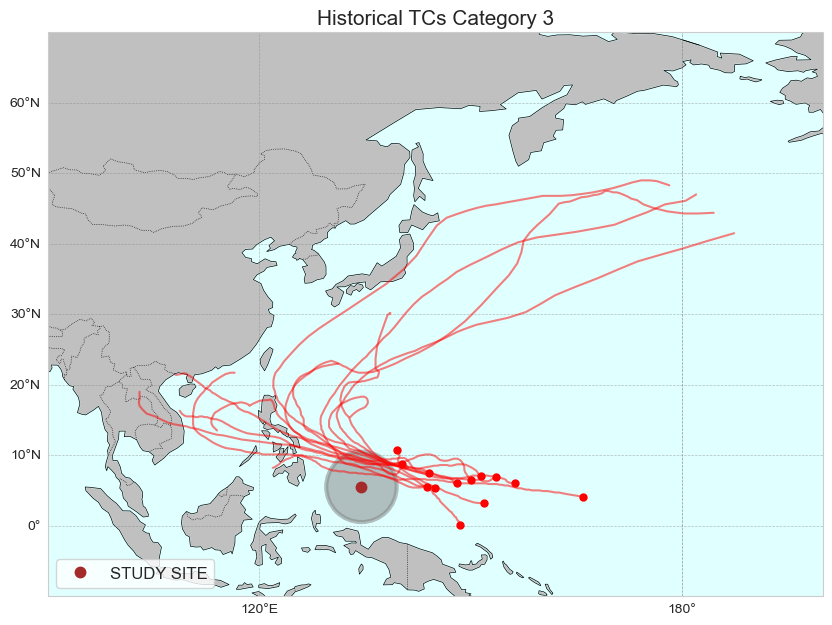

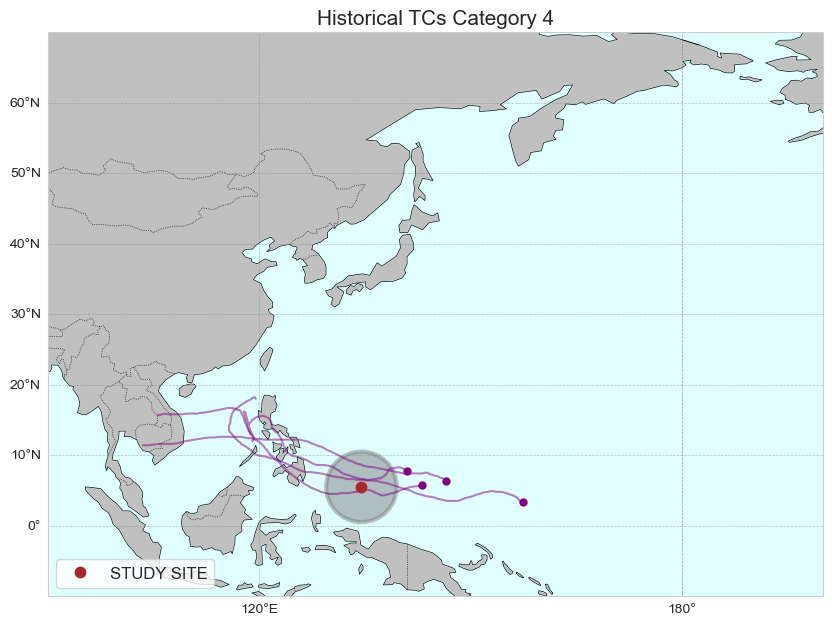

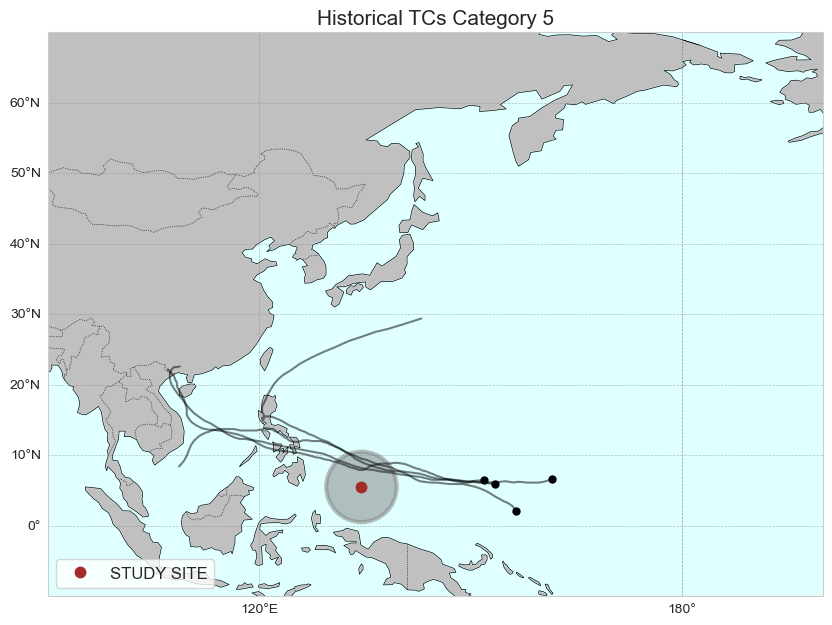

In [15]:

for category in range(6):
    tcs_cat = tcs_sel.where(tcs_sel_params.category == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.category == category, drop = True)

    # r1
    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs Category {category}', fontsize=15)

Number of TCs for each category

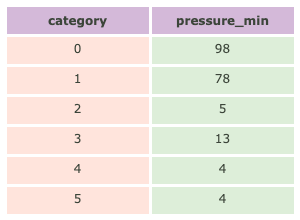

Mean TCs per year:  3.15625
Mean number of severe TCs per year:  1.17


In [16]:
df_t = df_tcs.groupby('category').count()[['pressure_min']]
fig = plot_df_table(df_t, figsize = (300, 220))

mean_tcs_per_year = df_tcs.groupby(df_tcs['dmin_date'].dt.year)['pressure_min'].count()

df_sev = df_tcs.loc[df_tcs['category'] >=3]
mean_tcs_per_year_sev = df_sev.groupby(df_sev['dmin_date'].dt.year)['pressure_min'].count()

print('Mean TCs per year: ', np.nanmean(mean_tcs_per_year))
print('Mean number of severe TCs per year: ', np.round(np.nanmean(mean_tcs_per_year_sev), 2))
